#### **IMPORTING NECESSARY DEPENDENCIES**

In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from pathlib import Path
import tensorflow as tf
from random import randint
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from distutils.dir_util import copy_tree, remove_tree
from sklearn.metrics import balanced_accuracy_score as BAS
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D

#### **Setting the seed for reproducibility**

In [2]:
tf.random.set_seed(1234)
random.seed(1234)

#### **Defining Variables**

In [3]:
EPOCHS = 30
BATCH_SIZE = 32
IMG_SIZE = 128
IMAGE_SIZE = [128, 128]
DIM = (IMG_SIZE, IMG_SIZE)

#### **Custom CNN (Real + Synthetic MRIs)**

In [4]:
train_dir = Path('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/train/')

# Get filepaths and labels
filepaths = list(train_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
train_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
train_df = train_df.sample(frac=1).reset_index(drop = True)

# Show the result
train_df.head(3)

Filepath                Label
0  /kaggle/input/best-alzheimer-mri-dataset-99-ac...        No Impairment
1  /kaggle/input/best-alzheimer-mri-dataset-99-ac...  Moderate Impairment
2  /kaggle/input/best-alzheimer-mri-dataset-99-ac...      Mild Impairment

In [5]:
test_dir = Path('/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset/test/')

# Get filepaths and labels
filepaths = list(test_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
test_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
test_df = test_df.sample(frac=1).reset_index(drop = True)

# Show the result
test_df.head(3)

Filepath                 Label
0  /kaggle/input/best-alzheimer-mri-dataset-99-ac...         No Impairment
1  /kaggle/input/best-alzheimer-mri-dataset-99-ac...  Very Mild Impairment
2  /kaggle/input/best-alzheimer-mri-dataset-99-ac...         No Impairment

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.0)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128,128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 1234,
    shuffle=False
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 1234,
    shuffle=False
)

CLASSES = list(test_images.class_indices.keys())

Found 10240 validated image filenames belonging to 4 classes.
Found 1279 validated image filenames belonging to 4 classes.


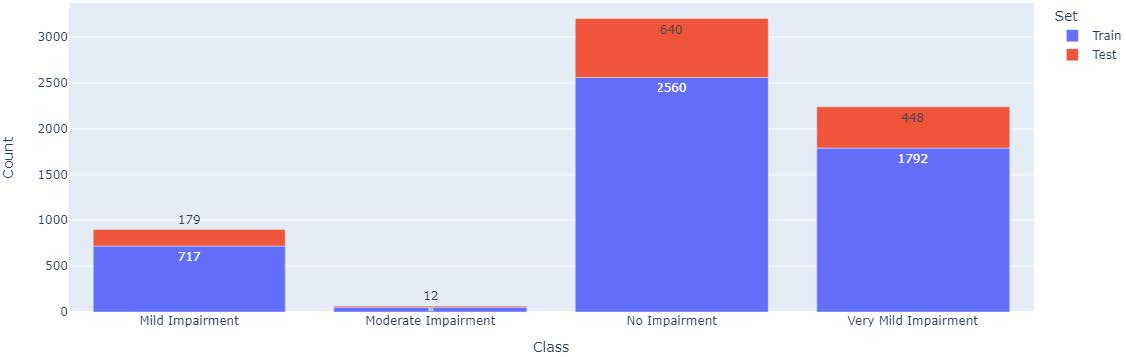

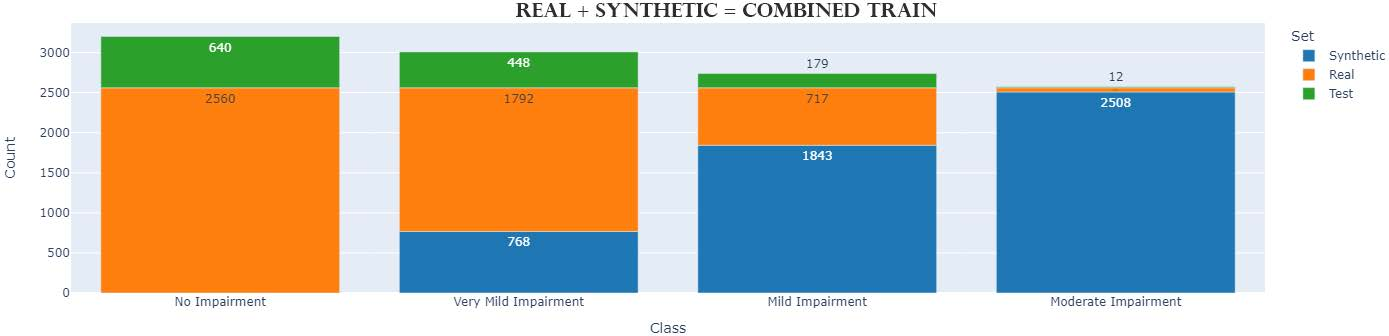

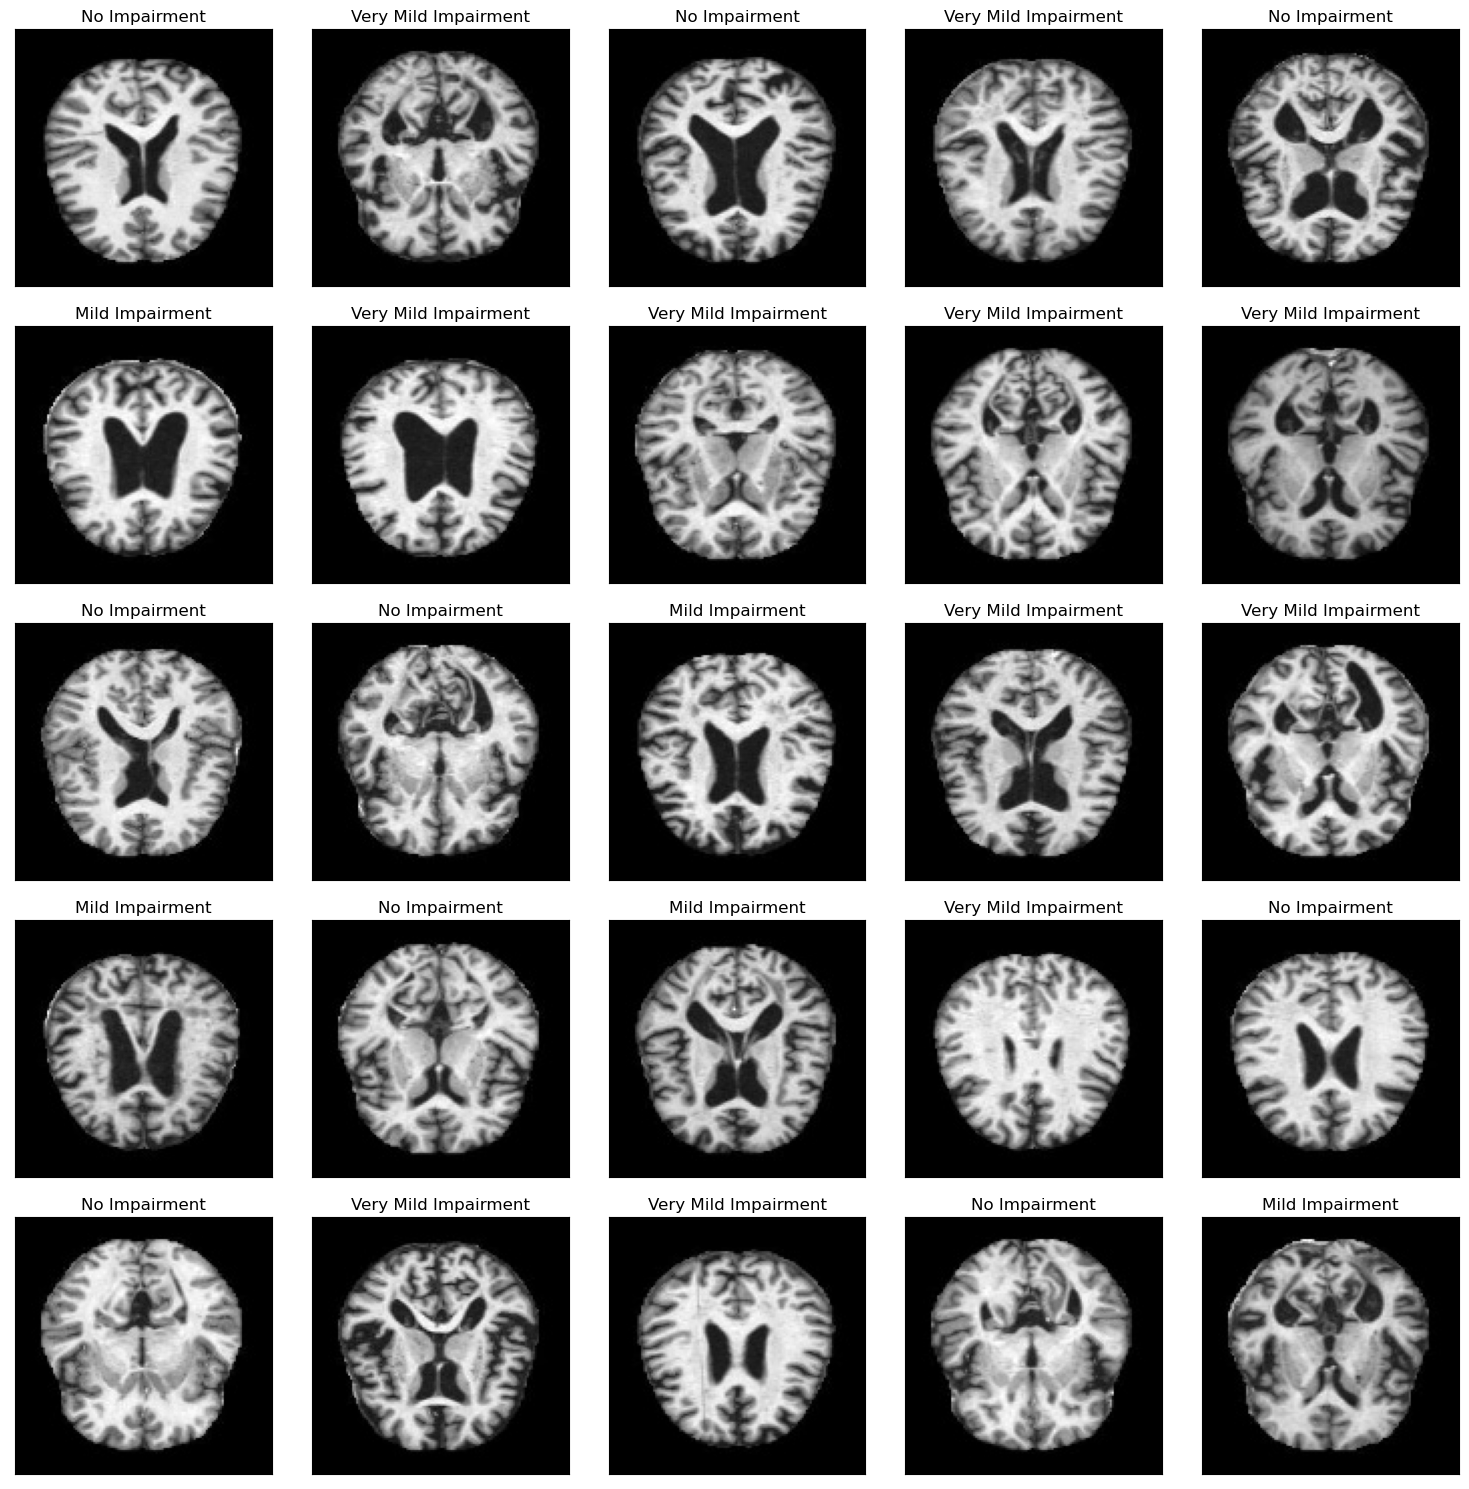

In [7]:
# Display 20 pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath[i]), cmap = 'gray')
    ax.set_title(test_df.Label[i])
plt.tight_layout()
plt.show()

In [8]:
custom_model_combined = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),
    Conv2D(16, 3, activation='relu', padding='same'),
    Conv2D(16, 3, activation='relu', padding='same'),
    MaxPool2D(),
    Conv2D(32, 3, activation='relu', padding='same'),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(64, 3, activation='relu', padding='same'),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(128, 3, activation='relu', padding='same'),
    Conv2D(128, 3, activation='relu', padding='same', name = 'last_conv_layer'),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.7),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(4, activation='softmax')        
], name = "cnn_model")

custom_model_combined.summary(line_length=100)

Model: "cnn_model"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d (Conv2D)                             (None, 128, 128, 16)                    448            
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 128, 128, 16)                    2320           
                                                                                                    
 max_pooling2d (MaxPooling2D)                (None, 64, 64, 16)                      0              
                                                                                                    
 conv2d_2 (Conv2D)                           (None, 64, 64, 32)                      4640           
                                                                        

In [9]:
OPT = tf.keras.optimizers.Adam(learning_rate=0.001)

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=4)]

custom_model_combined.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

In [10]:
def scheduler(epoch, lr):
    if epoch < 25:
        return lr
    else:
        return lr * np.exp(-0.1)
    
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

filepath = './best_weights.hdf5'

callback_list = [lr_scheduler]

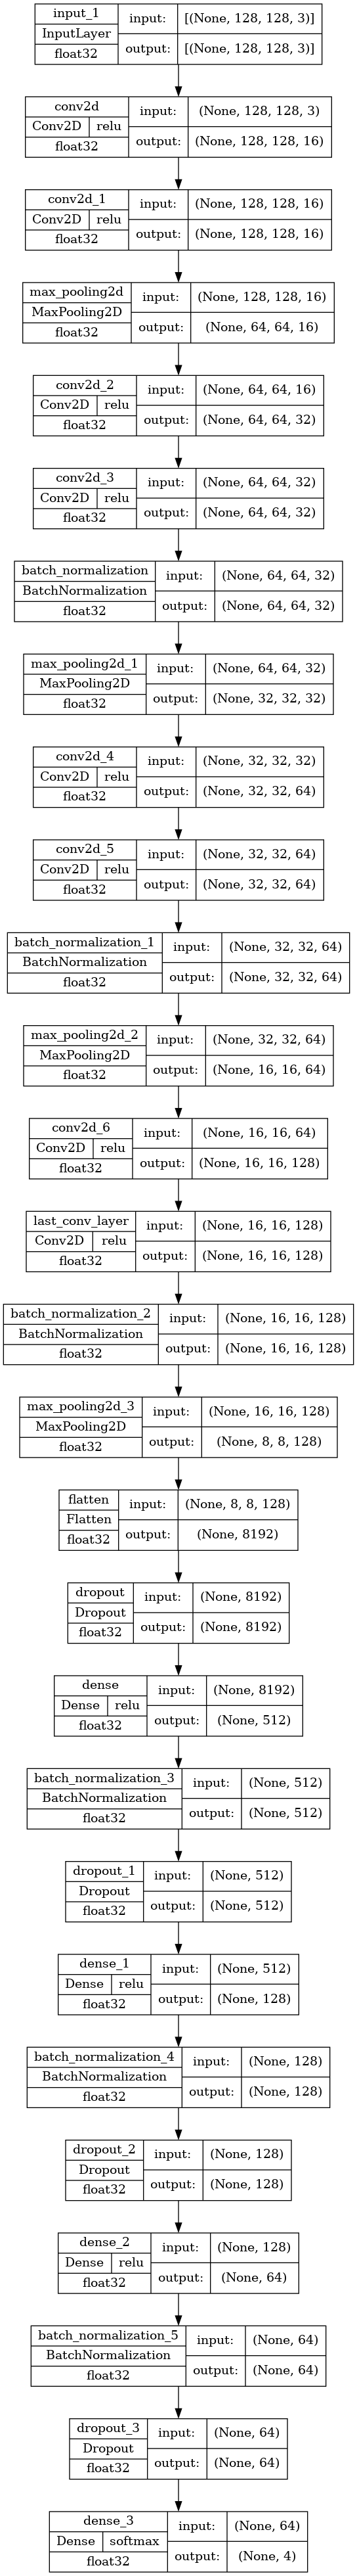

In [11]:
keras.utils.plot_model(custom_model_combined, to_file="model_architecture.png", show_shapes=True, show_dtype=True, 
                       show_layer_names=True, show_layer_activations=True)

In [12]:
custom_model_combined_history = custom_model_combined.fit(train_images,callbacks=callback_list, epochs=EPOCHS)

Epoch 1/30
320/320 [==============================] - 86s 227ms/step - loss: 1.0596 - acc: 0.5611 - auc: 0.8171 - f1_score: 0.5512 - lr: 0.0010
Epoch 2/30
320/320 [==============================] - 13s 41ms/step - loss: 0.6467 - acc: 0.7110 - auc: 0.9255 - f1_score: 0.7086 - lr: 0.0010
Epoch 3/30
320/320 [==============================] - 13s 42ms/step - loss: 0.5342 - acc: 0.7623 - auc: 0.9483 - f1_score: 0.7618 - lr: 0.0010
Epoch 4/30
320/320 [==============================] - 14s 43ms/step - loss: 0.4971 - acc: 0.7782 - auc: 0.9551 - f1_score: 0.7778 - lr: 0.0010
Epoch 5/30
320/320 [==============================] - 14s 42ms/step - loss: 0.4652 - acc: 0.7931 - auc: 0.9605 - f1_score: 0.7929 - lr: 0.0010
Epoch 6/30
320/320 [==============================] - 14s 42ms/step - loss: 0.4017 - acc: 0.8250 - auc: 0.9707 - f1_score: 0.8246 - lr: 0.0010
Epoch 7/30
320/320 [==============================] - 13s 42ms/step - loss: 0.3700 - acc: 0.8395 - auc: 0.9750 - f1_score: 0.8389 - lr: 0.001

In [13]:
test_scores = custom_model_combined.evaluate(test_images)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))
pred_labels = custom_model_combined.predict(test_images)

def roundoff(arr):
    """To round off according to the argmax of each predicted label array."""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
    
pred = np.argmax(pred_labels,axis=1)

print(classification_report(test_images.classes,pred,target_names=CLASSES))

40/40 [==============================] - 11s 273ms/step - loss: 0.0745 - acc: 0.9765 - auc: 0.9978 - f1_score: 0.9596
Testing Accuracy: 97.65%
40/40 [==============================] - 2s 37ms/step
                      precision    recall  f1-score   support

     Mild Impairment       0.99      0.96      0.98       179
 Moderate Impairment       1.00      0.83      0.91        12
       No Impairment       0.99      0.98      0.98       640
Very Mild Impairment       0.96      0.98      0.97       448

            accuracy                           0.98      1279
           macro avg       0.98      0.94      0.96      1279
        weighted avg       0.98      0.98      0.98      1279



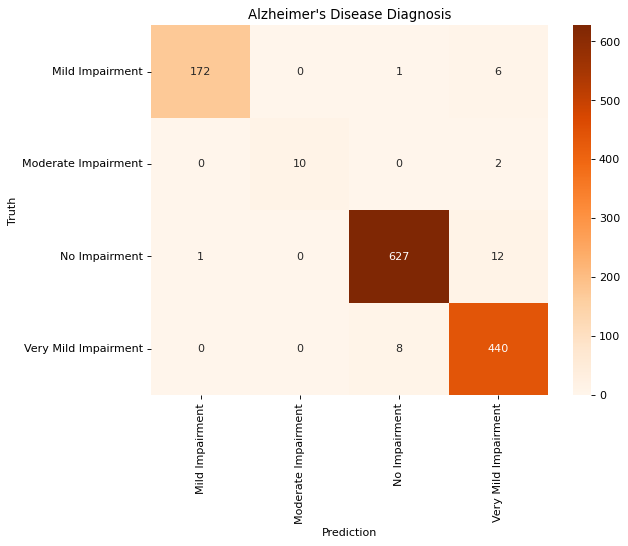

In [14]:
# Plot the confusion matrix to understand the classification in detail

test_ls, pred_ls = test_images.classes,pred
conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Oranges', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [15]:
#Printing some other classification metrics
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 93.9 %
Matthew's Correlation Coefficient: 96.14 %


In [16]:
custom_model_combined.save('custom_cnn_(combined)_(9.69%).h5')

#### **GRAD-CAMs**

This was done by extracting the gradients from the last convolutional layer, for each image, which were then overlapped on top of that particular image in form of a heatmap to visualize which parts of the image did the classifier focussed on, in order to make its classification decisions.

The following figure will clearly illustrate the regions responsible for classification in a hierarchy using a colour-bar in which “red” indicates the region where the classifier focused the most followed by “orange”, “yellow”, “green” and finally “blue” indicating the regions where it focussed the least. These images were classified with 100% accuracy which can also be seen by the ground truth and the predicted label on top of each image.

Researchers and medical professionals can benefit from using grad-cams (explainable AI) to identify the indicators of Alzheimer’s for each stage. Additionally, in the future, if an application is developed that automates the diagnosis of Alzheimer’s disease, clinicians could then utilize the grad-cam feature in the application to interpret and confirm the classification decisions for each person's MRI

In [17]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
                                      
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path))
    
    return cam_path

import matplotlib.cm as cm
img_size = IMAGE_SIZE

# Remove last layer's softmax
custom_model_combined.layers[-1].activation = None

last_conv_layer_name = "last_conv_layer"

In [18]:
pred_labels = custom_model_combined.predict(test_images)

def roundoff(arr):
    """To round off according to the argmax of each predicted label array."""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
    
pred = np.argmax(pred_labels,axis=1)

# Map the label to respective classes
labels = (test_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

40/40 [==============================] - 2s 40ms/step


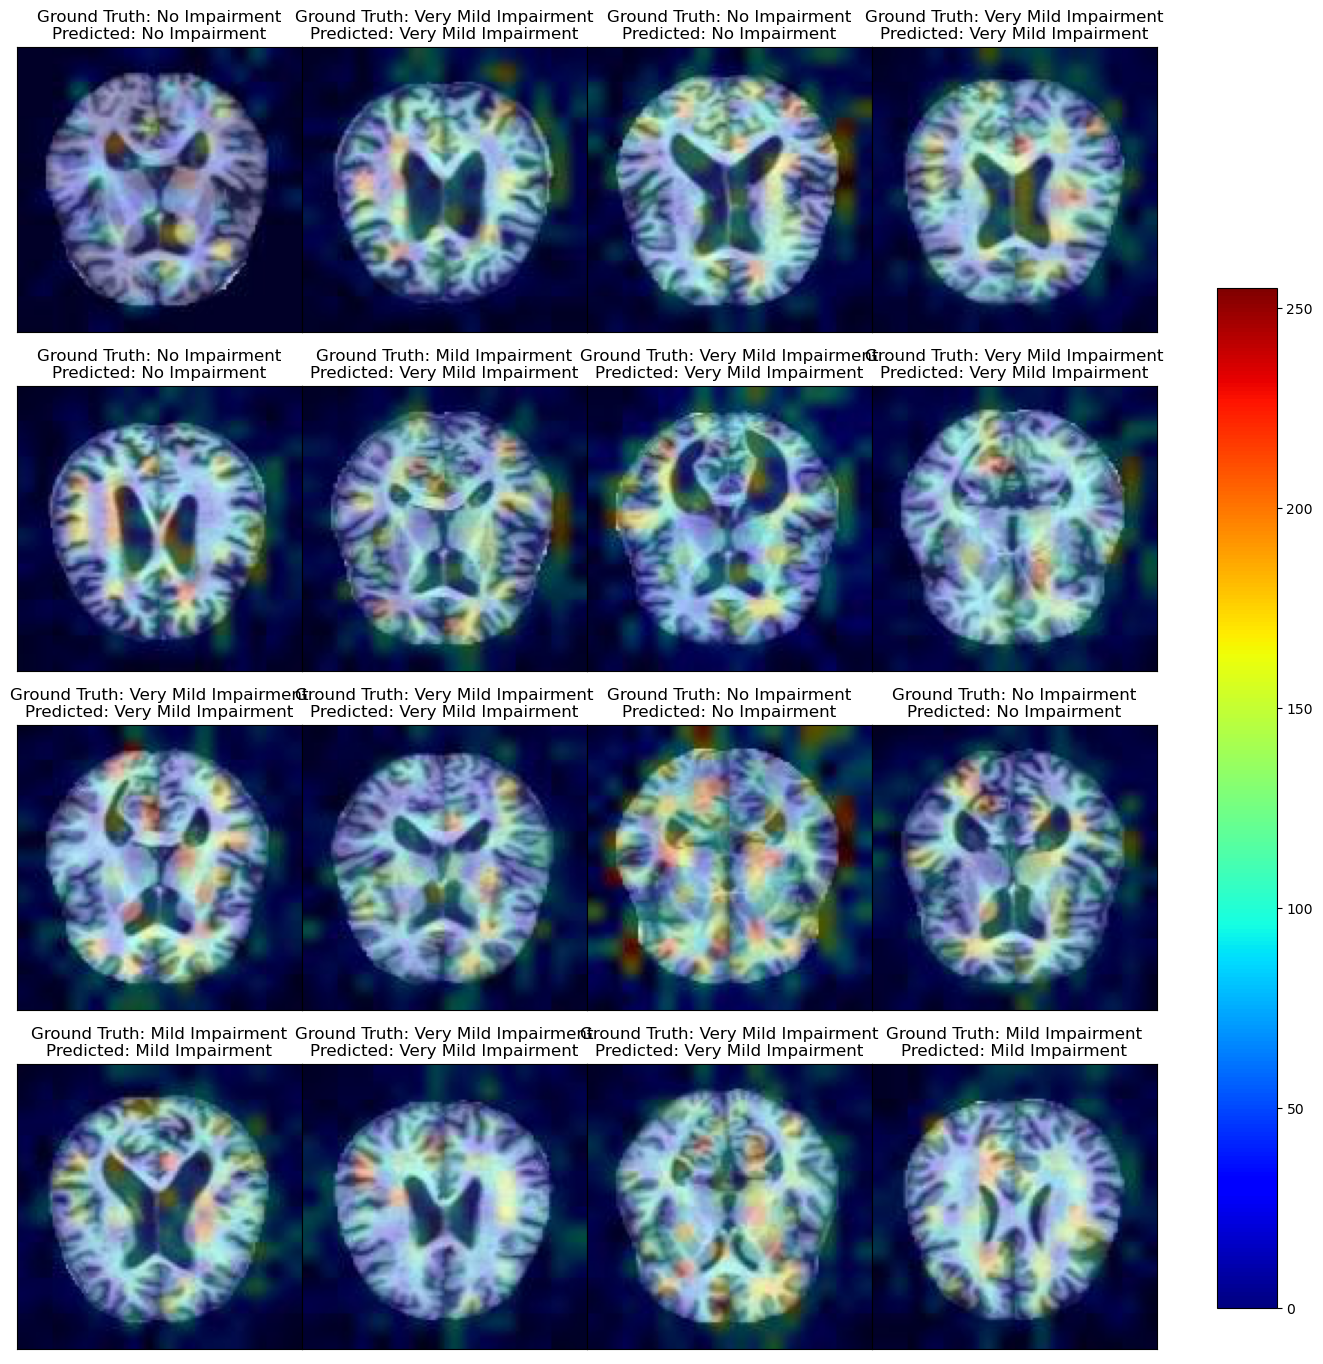

In [19]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
                        
for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i+545]
    img_array = get_img_array(img_path, size=img_size)
    heatmap = make_gradcam_heatmap(img_array, custom_model_combined, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    cbar = ax.imshow(plt.imread(cam_path),cmap='jet')
    ax.set_title(f"Ground Truth: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
cbar_ax = fig.add_axes([1.0, 0.057, 0.05, 0.85])
plt.colorbar(cbar, cax=cbar_ax)
plt.savefig("grad_cam.jpg")
plt.subplots_adjust(left=0, bottom=0, right=1, top=1.13, wspace=0, hspace=0)
plt.subplots_adjust(right=0.95)
plt.show()

In [20]:
def get_img_array_spring(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap_spring(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
                                      
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam_spring(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use spring colormap to colorize heatmap
    spring = cm.get_cmap("spring")

    # Use RGB values of the colormap
    spring_colors = spring(np.arange(256))[:, :3]
    spring_heatmap = spring_colors[heatmap]

    # Create an image with RGB colorized heatmap
    spring_heatmap = tf.keras.preprocessing.image.array_to_img(spring_heatmap)
    spring_heatmap = spring_heatmap.resize((img.shape[1], img.shape[0]))
    spring_heatmap = tf.keras.preprocessing.image.img_to_array(spring_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = spring_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    # display(Image(cam_path))
    
    return cam_path

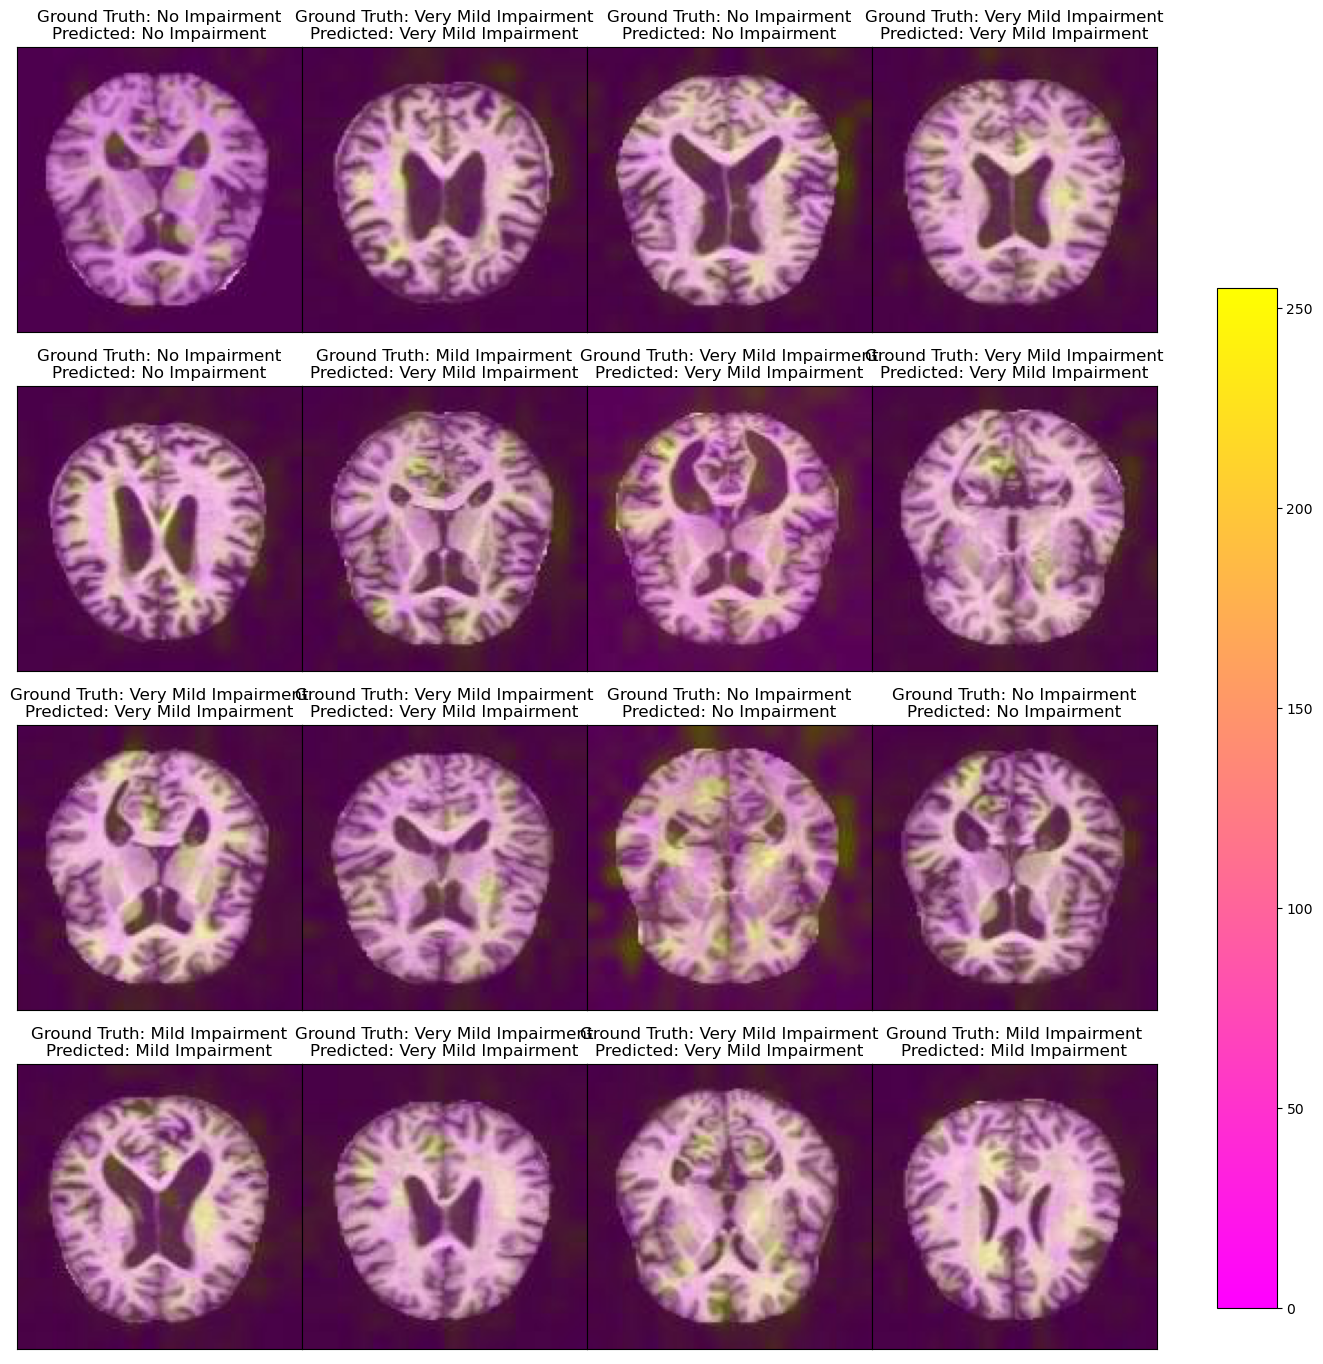

In [21]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})
                        
for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i+545]
    img_array = get_img_array_spring(img_path, size=img_size)
    heatmap = make_gradcam_heatmap_spring(img_array, custom_model_combined, last_conv_layer_name)
    cam_path = save_and_display_gradcam_spring(img_path, heatmap)
    cbar = ax.imshow(plt.imread(cam_path),cmap='spring')
    ax.set_title(f"Ground Truth: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
cbar_ax = fig.add_axes([1.0, 0.057, 0.05, 0.85])
plt.colorbar(cbar, cax=cbar_ax)
plt.savefig("grad_cam_spring.jpg")
plt.subplots_adjust(left=0, bottom=0, right=1, top=1.13, wspace=0, hspace=0)
plt.subplots_adjust(right=0.95)
plt.show()